# Trading-Data-Science
Kindly use as notes for time series information about **stocks**. We will make some things that might look repetitve, however we aim to show different methods to analyze time series data (though some might not be very smart, but we try to make this as illustrative as possible). <br> 
This is only **price prediction** aproximation however no trading strategy (rule based policy) please look at RL notebook.

# Thecnical analysis
More specifically in this notebook we will explore different time series methods using financial information, however, we will not explore deeply on financial technical analysis such as Bollinger bands. 
The source is Udemy's Python for time series data analysis and Youtube Channel ritvikmath.

## Time Series
A series of data points collected in time order is known as a time series. Consists of data that is collected, recorded or observed over succesive increments of time. For forecasting we take into account previous time. So for example, we suppose that price of tesla stock at a given time in the past can help us predict tesla stock in the future. However, this is not completely true, taking into account that data is related with other things such as other stocks, unemployment, gdp, etc. In conclusion the data of today is affected by the data of yesterday and the day before and the one before and so on. Remember first you have to generate hypothesis of all posible situations regarding trend and seasonality.
We want to predict future values based on previously observed values.
#### Trend component: 
Is a general direction in which something is developing or changing
#### Cyclical component
Is a wavelike fluctuation around the trend.
#### Seasonal component
The pattern is reapiting at a regular time interval. Is a pattern of change that reapats itself time after time (year after year).
First you have to generate hypothesis of all posible situations regarding trend and seasonality.

In [2]:
from datetime import datetime 
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from pandas import Series

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
#Using kimberly Clark stock price, since look a bit more stationary than other stocks
path = "KMB.csv" #from december 15, 2015
tsla_path = "TSLA.csv"

In [4]:
train = pd.read_csv(path)
train_original = train.copy()

In [5]:
train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
train.shape

(1259, 7)

In [7]:
train.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
train["Adj Close"].describe()

count    1259.000000
mean      116.740156
std        14.999161
min        90.186562
25%       106.060852
50%       112.227409
75%       129.931160
max       156.533905
Name: Adj Close, dtype: float64

In [9]:
train['Date'] = pd.to_datetime(train.Date, format = '%Y-%m-%d')

In [10]:
#To make segregate data based on day, month, year or hour we do the following:
train['year'] = train.Date.dt.year
train['month'] = train.Date.dt.month
train['day'] = train.Date.dt.day
train['hour'] = train.Date.dt.hour
train['day_of_week'] = train['Date'].dt.dayofweek
# Makes no sense to perform weekend
temp = train['day_of_week'].apply(lambda x: 1  if x == 5 or x == 6 else 0)
train['weekend'] = temp
train.index = train['Date']

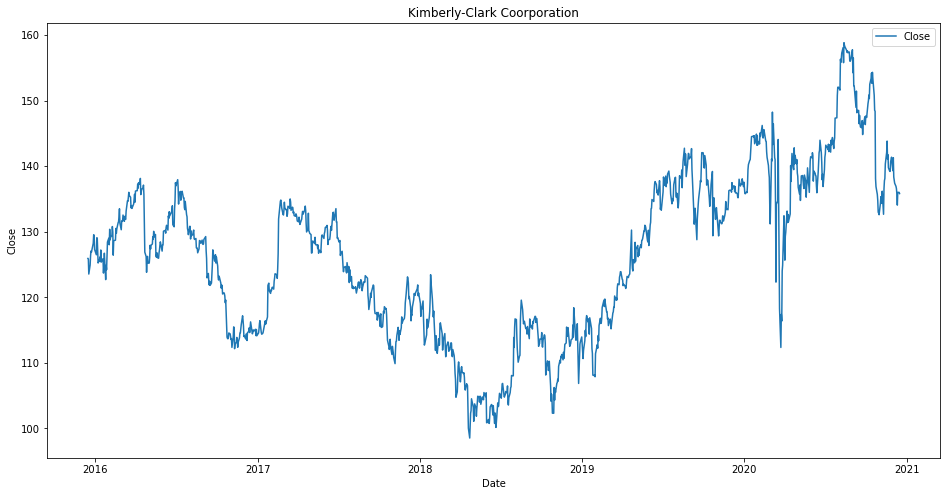

In [11]:
ts = train['Close']
plt.figure(figsize = (16, 8))
plt.plot(ts, label = 'Close')
plt.title('Kimberly-Clark Coorporation')
plt.xlabel("Date")
plt.ylabel('Close')
plt.legend(loc = 'best')
plt.show()

### The found below will be very useful for any time series prior analysis. Since you can find patterns.

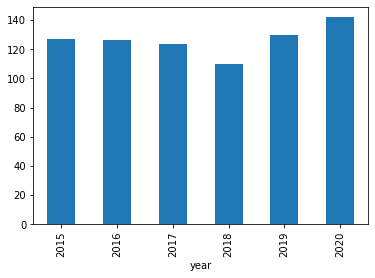

In [12]:
train.groupby('year')['Close'].mean().plot.bar()

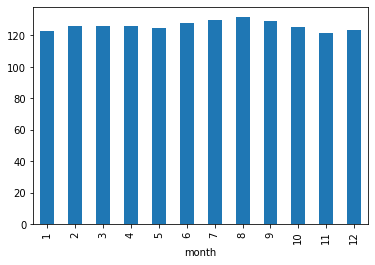

In [13]:
#we can say Adjusted close price remains similar through all months
train.groupby('month')['Close'].mean().plot.bar()

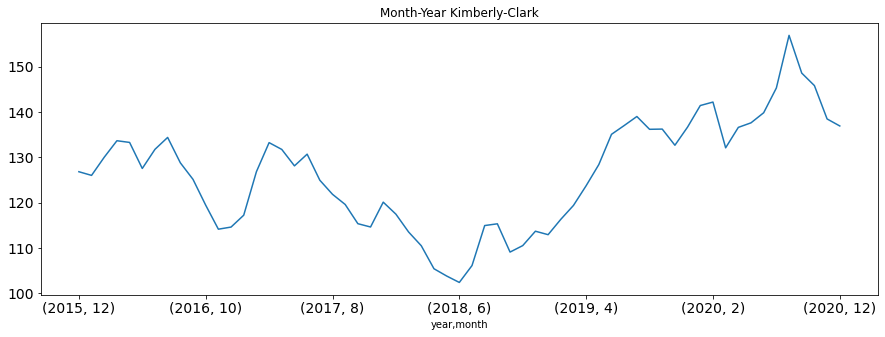

In [14]:
# There might be an increasing demand from 2019 to 2020. Seen through month and year.
temp = train.groupby(['year', 'month'])['Close'].mean()
temp.plot(figsize=(15, 5), title = 'Month-Year Kimberly-Clark', fontsize = 14)

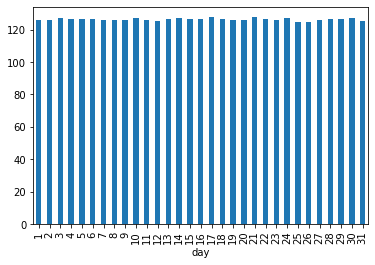

In [15]:
train.groupby('day')['Close'].mean().plot.bar()

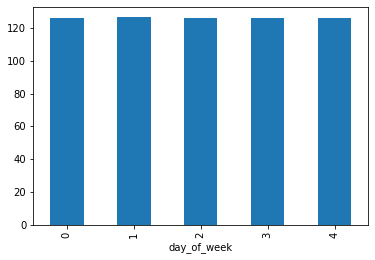

In [16]:
train.groupby('day_of_week')['Close'].mean().plot.bar()

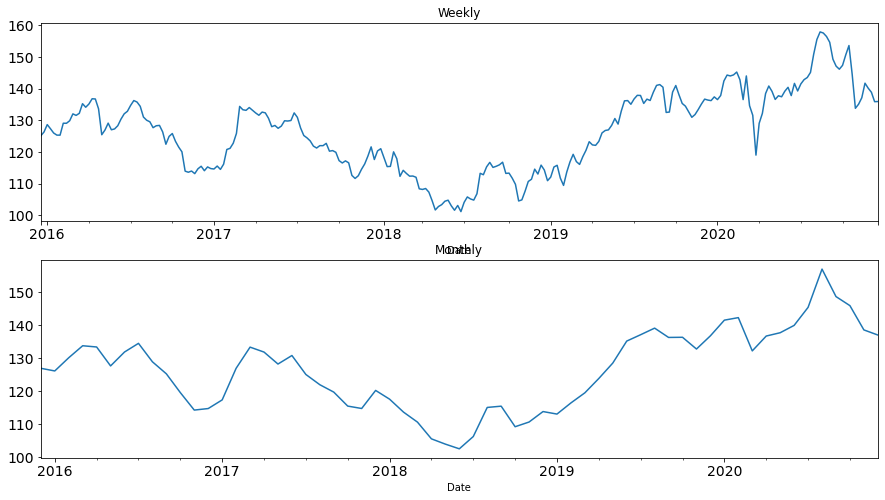

In [17]:
#Weekly time series
weekly = train.resample('W').mean()
#Monthly time series
monthly = train.resample('M').mean()

fig, axs = plt.subplots(2, 1)
weekly.Close.plot(figsize = (15, 8), title = 'Weekly', fontsize = 14, ax = axs[0])
monthly.Close.plot(figsize = (15, 8), title = 'Monthly', fontsize = 14, ax = axs[1])

### Train-test split
When working with time series it is not useful to do random splitting because it might not work for the validate, probably for the train not for the validation.

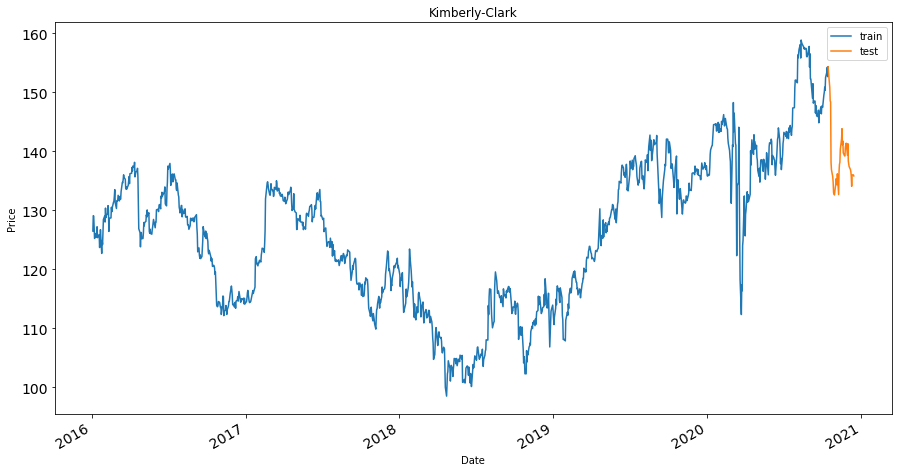

In [18]:
valid = train.loc['2020-10-15':'2020-12-15']
train = train.loc['2016-01-01':'2020-10-15']
train.Close.plot(figsize = (15, 8), title = 'Kimberly-Clark', fontsize = 14, label = 'train')
valid.Close.plot(figsize = (15, 8), title = 'Kimberly-Clark', fontsize = 14, label = 'test')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = 'best')
plt.show()

### Modeling techniques
1. Naive approach
2. Moving average
3. Simple exponential smoothing
4. Holt's Linear Trend Model
5. And many more...

#### In order to calculate how accurate are our predictions we can use rmse
rmse = standard deviation of the residuals

### Naive

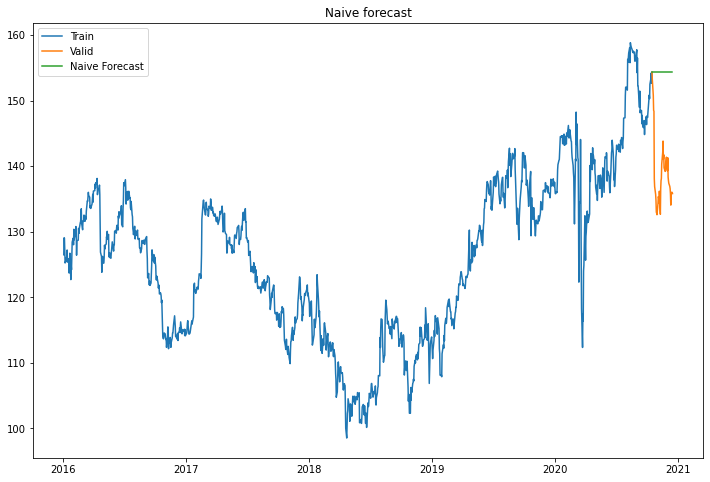

Root Mean Squared Error:
16.247997038592473


In [19]:
dd = np.asarray(train.Close)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
# Or just dd[-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Close'], label = 'Train')
plt.plot(valid.index, valid['Close'], label = 'Valid')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title('Naive forecast')
plt.show()

rms = sqrt(mean_squared_error(valid.Close, y_hat.naive))
print("Root Mean Squared Error:")
print(rms)

### Moving Average
for 7, 10, 20, 50 days

In [20]:
#seven days easy calculation
train["Adj Close"].iloc[-7:].mean()

151.42253985714288

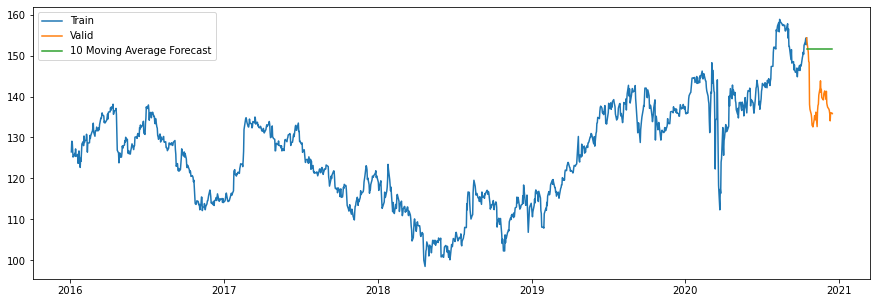

Root Mean Squared Error:
13.624713977386369


In [21]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (15, 5))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Close'], label = 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label = '10 Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
print(sqrt(mean_squared_error(valid.Close, y_hat_avg.moving_avg_forecast)))

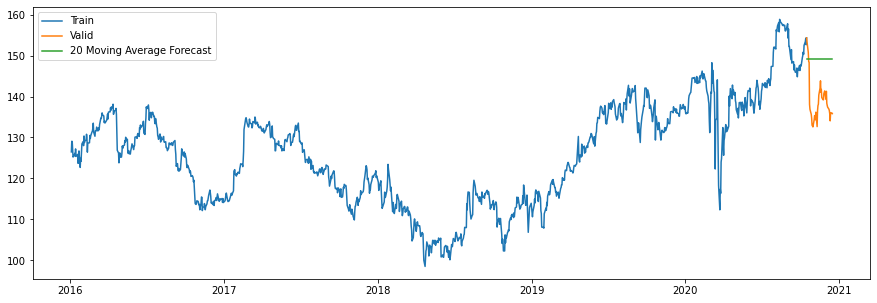

Root Mean Squared Error:
11.380011260588025


In [22]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(20).mean().iloc[-1]
plt.figure(figsize = (15, 5))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Close'], label = 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label = '20 Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
print(sqrt(mean_squared_error(valid.Close, y_hat_avg.moving_avg_forecast)))

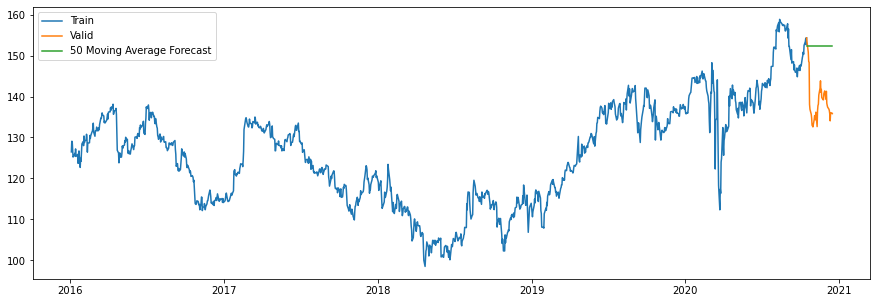

Root Mean Squared Error:
14.318005519017664


In [23]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(50).mean().iloc[-1]
plt.figure(figsize = (15, 5))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Close'], label = 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label = '50 Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
print(sqrt(mean_squared_error(valid.Close, y_hat_avg.moving_avg_forecast)))

### Simple Exponential Smoothing
Please try different smoothing levels

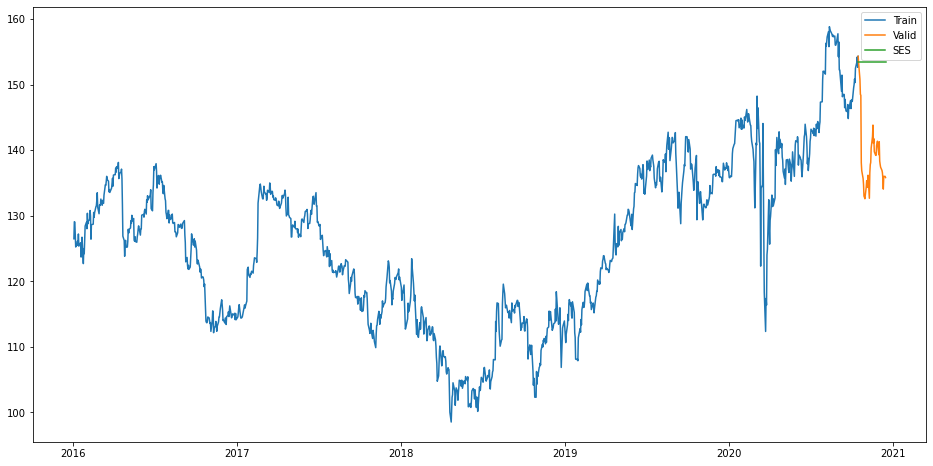

Root Mean Squared Error:
15.367235714877852


In [24]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level = 0.4, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize = (16, 8))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Close'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'SES')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
print(sqrt(mean_squared_error(valid.Close, y_hat_avg.SES)))

### Holt's linear trend is an extension of simple exponential smoothing to allow forecast of data with trend.
Decompose the time series in four parts:
* Observed Original time series
* Trend Shows the trend (increasing or deacrising)
* Seasonal Tells us about the seasonality in the time series
* Resuidual Obtained by removing any trend or seasonality in the time series

In [25]:
tsla = pd.read_csv(tsla_path, index_col = 'Date', parse_dates = ['Date'])
tsla.dropna(inplace = True)
tsla.index

tsla_valid = tsla.loc['2020-10-15':'2020-12-15']
tsla_train = tsla.loc['2010-06-30':'2020-10-15']

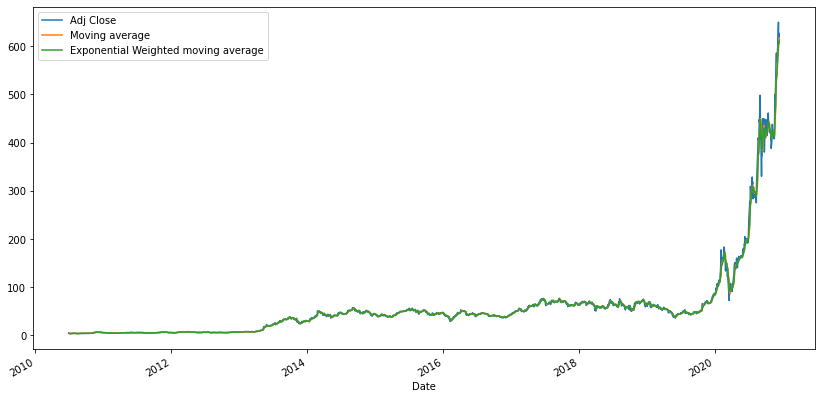

In [26]:
tsla["Adj Close"].plot(figsize = (14, 7))
#7 days moving average
tsla["Adj Close"].rolling(window=7).mean().plot(label = "Moving average")
#exponentil weighted moving average
#can move alpha, com and span
#Simple exponential moving average
tsla["Adj Close"].ewm(span=7).mean().plot(label = "Exponential Weighted moving average")
plt.legend()
plt.show()

### Explanation of expanding
Instad of having a fixed value for calculating the mean, expanding calculates, the mean for example, of all the observations througout time

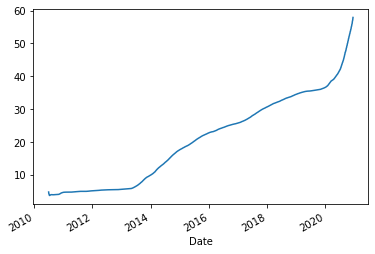

In [27]:
tsla['Adj Close'].expanding().mean().plot()
plt.show()

In [28]:
tsla = tsla.resample('B').asfreq()
tsla.fillna(method='ffill', inplace = True)

### Trend Seasonality and Cycles
### ETS Models (Error Trend Seasonality)
##### Additive vs. multiplicative model: When linear trend the former, when exponential the latter.
The two simplest models relating the observed values _Y_ of a time series to the trend _T_, seasonal _S_ and irregular _I_ components are additive (when having roughly the same variability):<br>
_Y_ = _T_ + _S_ + _I_<br>
And the multiplicative (Variability increasing with level):<br>
_Y_ = _T_ x _S_ x _I_

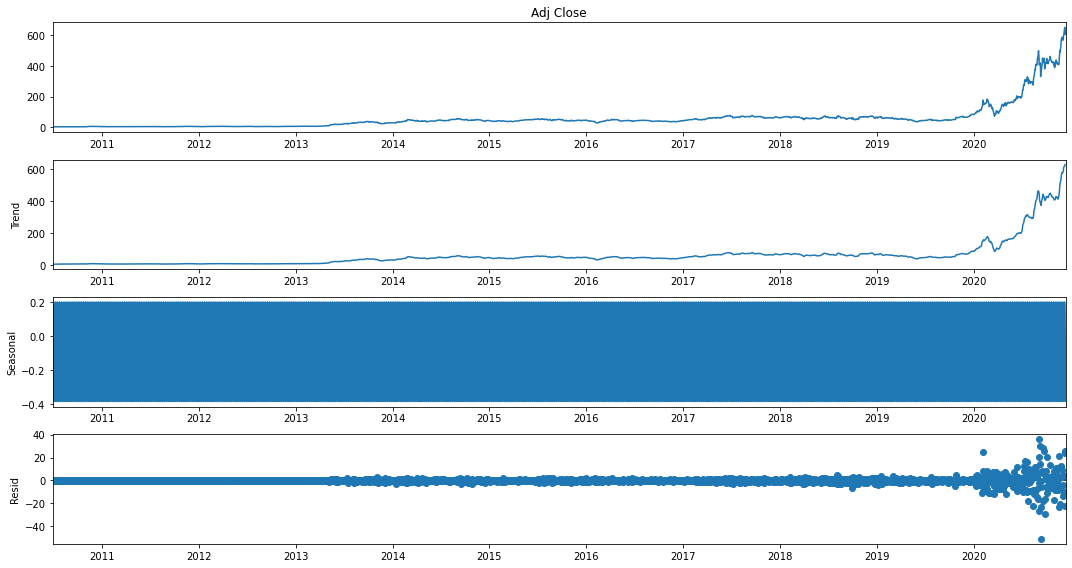

In [29]:
rcParams["figure.figsize"]=15, 8
#I select additive, due to the fact that seems not to follow a linear trend
decompose = seasonal_decompose(tsla['Adj Close'], model = "additive")
decompose.plot();
#Keep that semi-colon to avoid repeating plots

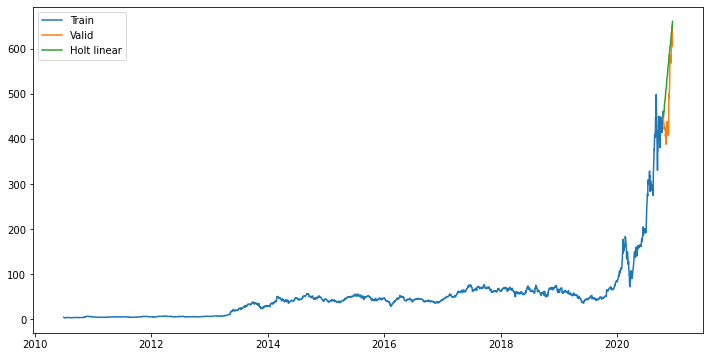

Root Mean Squared Error:
82.66067214108271


In [30]:
y_hat_avg = tsla_valid.copy()
#remember that alph beta and gamma cannot be negative
fit1 = Holt(np.asarray(tsla_train['Adj Close'])).fit(smoothing_level = 0.17, smoothing_slope = 0.5)
y_hat_avg['Holt_linear'] = fit1.forecast(len(tsla_valid))
plt.figure(figsize = (12, 6))
plt.plot(tsla_train['Adj Close'], label = 'Train')
plt.plot(tsla_valid['Adj Close'], label = 'Valid')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt linear')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
rms = sqrt(mean_squared_error(tsla_valid["Adj Close"], y_hat_avg.Holt_linear))
print(rms)

### Double Exponential Smoothing

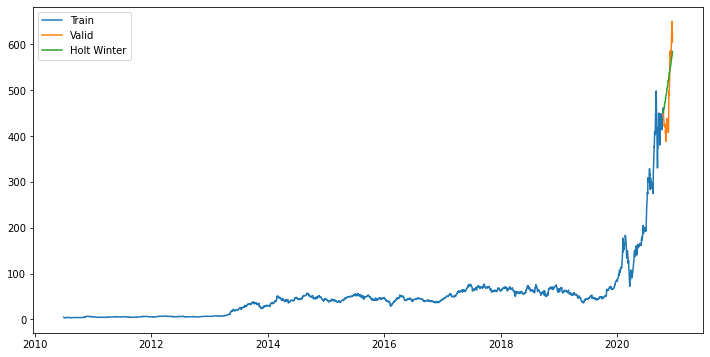

Root Mean Squared Error:
61.446633735139166


In [31]:
y_hat_avg = tsla_valid.copy()
fit1 = ExponentialSmoothing(np.asarray(tsla_train["Adj Close"]), seasonal_periods = 5, trend = 'multiplicative', seasonal = 'add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(tsla_valid))
plt.figure(figsize=(12, 6))
plt.plot(tsla_train['Adj Close'], label = 'Train')
plt.plot(tsla_valid['Adj Close'], label = 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt Winter')
plt.legend(loc='best')
plt.show()
print("Root Mean Squared Error:")
rms = sqrt(mean_squared_error(tsla_valid["Adj Close"], y_hat_avg.Holt_Winter))
print(rms)

### Variations through time

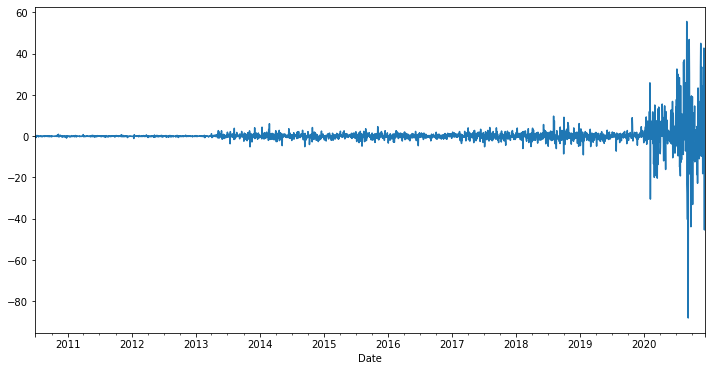

In [32]:
rcParams["figure.figsize"]=12, 6
diff(tsla["Adj Close"], k_diff=1).plot()

### ARIMA stands for Auto Regressive Integrated Moving Average:
Improved by the works of G.E.P. Box and G.M. Jenkins, that is why is sometimes refered as Box-Jenkins methodology.<br>
**warning:** ARIMA only works if problem is in function of time. However to place into practice we are going to use stock price data. More variables need to be added to the problem in order to be accurately forecasted.
* Non seasonal ARIMA
* Seasonal ARIMA (SARIMAX)
* Seasonal ARIMA with exogenous variables (SARIMAX)

3 order parameters:
* p = autoregressive model (number of time lags). Autoregression, regressed on its own lag. Number of lag observations included in the model.
* d = degree of diferencing. Integrated, differencing of observations (how many times we difference the data to get it stationary). If d= 0 then stationary, if d > 0 then non-stationary.
* q = orderd of moving average model. Linear combination of error terms<br>

**Moving average** model takes into account the error of the previous period, for basic MA(1), you can take into account errors of previous observations.

Stationary means, costant mean and variance over time, try Dickey-Fuller test. For ARIMA we need stationary data, through differencing we are going to search for that.<br>
Granger causality test if one time series is useful in forecasting another.<br>
AIC, evaluates a collection of models and estimates the quality of eachone with one another. Penalties a lot of variables to avoid overfitting

#### First we have to make sure that the data is stationary
**Dickey Fuller**:
* null hypothesis = time series is not stationary
* alternative hypothesis = it is stationary
Stationarity means a flat series in other words without a trend.

#### Remember: It works good when there are no outliers/pulses/level shifts

In [33]:
#returning Test_statistic, p_value, #Lag Used, Number of Observations used
result = sm.tsa.stattools.adfuller(tsla['Adj Close'])
result
#Clearly shows data is not stationary

(7.809445962455706,
 1.0,
 28,
 2699,
 {'1%': -3.4327751686716304,
  '5%': -2.8626114613655744,
  '10%': -2.5673403744927143},
 15687.534180948769)

### Granger Causality Test
Test if one time series is usefull in forecasting another. Ability to predict future values using past values, be carefull about **post hoc fallacy**. For example, say a particular organization is tanking the same actions that the competition, however those actions shall be done by the competitor, therefore competitors action in time _t_ will be given organization in time _t + 1_. And we can predict given organization actions. in other words competitor actions **GRANGER CAUSES** given organization.

In [34]:
a = tsla["Adj Close"].iloc[2:]
b = tsla["Adj Close"].shift(2)
#just use 5 to not plot all here
gct = grangercausalitytests(pd.DataFrame({'a':a, "b":b}).dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8843  , p=0.0153  , df_denom=2722, df_num=1
ssr based chi2 test:   chi2=5.8908  , p=0.0152  , df=1
likelihood ratio test: chi2=5.8845  , p=0.0153  , df=1
parameter F test:         F=5.8843  , p=0.0153  , df_denom=2722, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=16.4770 , p=0.0000  , df_denom=2719, df_num=2
ssr based chi2 test:   chi2=33.0147 , p=0.0000  , df=2
likelihood ratio test: chi2=32.8162 , p=0.0000  , df=2
parameter F test:         F=16.4770 , p=0.0000  , df_denom=2719, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.5115 , p=0.0000  , df_denom=2717, df_num=3
ssr based chi2 test:   chi2=31.6042 , p=0.0000  , df=3
likelihood ratio test: chi2=31.4222 , p=0.0000  , df=3
parameter F test:         F=11.3212 , p=0.0000  , df_denom=2717, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1204  , p=0.

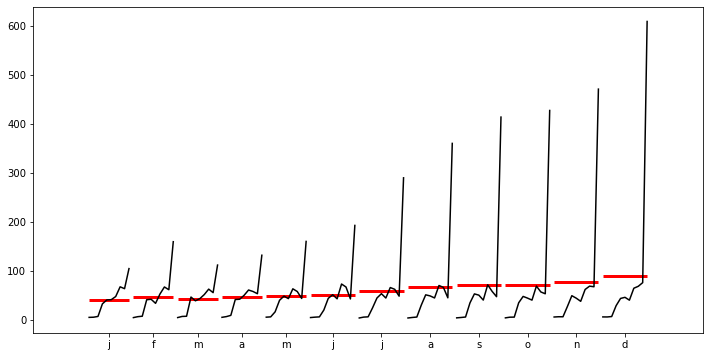

In [35]:
#You have to reindex
month_plot(tsla["Adj Close"].resample(rule="M").mean());

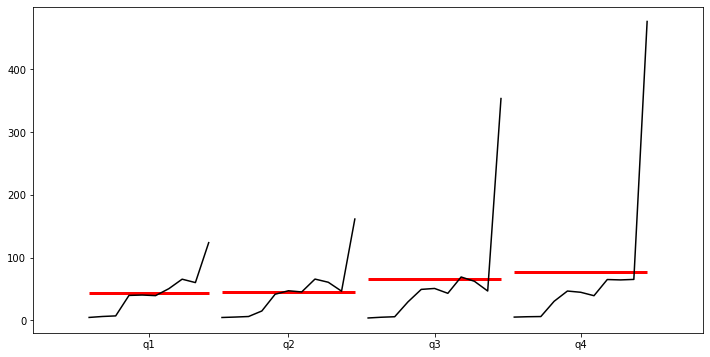

In [36]:
quarter_plot(tsla["Adj Close"].resample(rule="Q").mean());

### Making data stationary
Substract time series in t time minus lagged by n time series.<br>
**Remember** if your time series is white noise, then cannot be predicted:
* Mean 0
* Correlation between lags is zero (ACF all close to zero)
* Variance is constant with time

https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary

### Log:
Effective at removing exponential variance (values need to be positiva and non-negative). We can use it to remove trends and cycles.

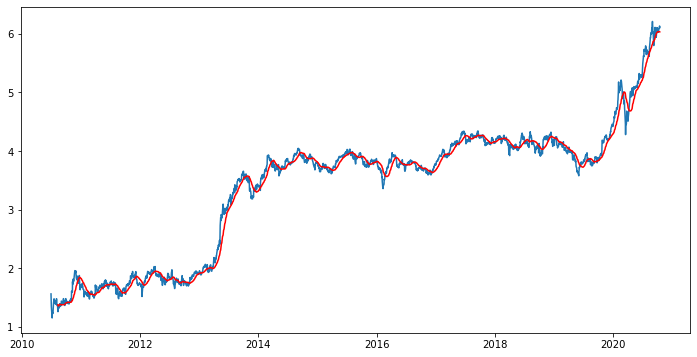

In [37]:
train_log = np.log(tsla_train['Adj Close'])
valid_log = np.log(tsla_valid['Adj Close'])
moving_avg = train_log.rolling(30).mean()
plt.plot(train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

### Trying to remove seasonality

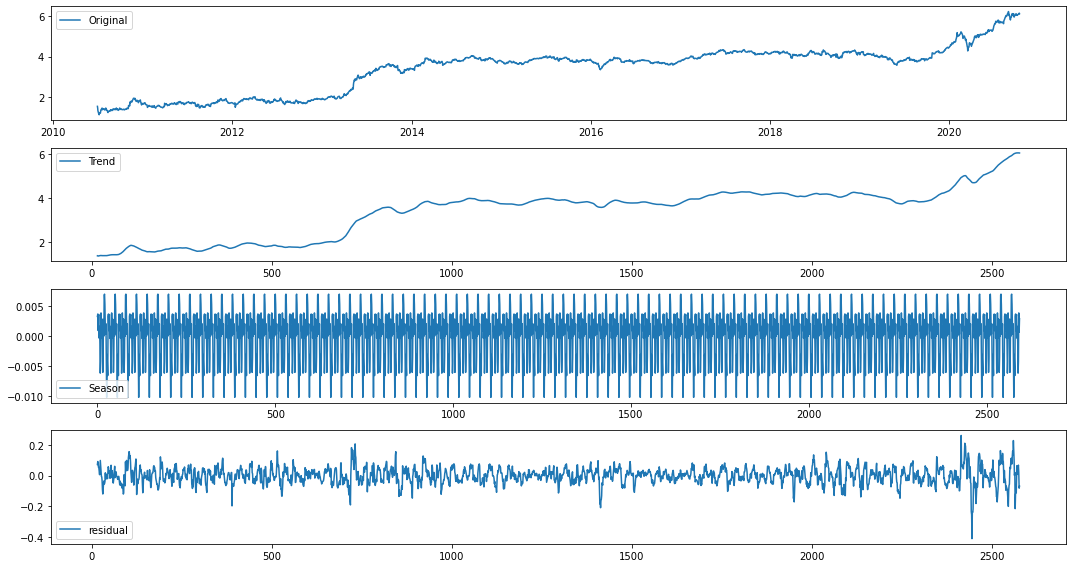

In [38]:
rcParams["figure.figsize"]=15, 8
#later use same login for Kimberly-Clark
train_log_mov_avg_diff = train_log - moving_avg
train_log_mov_avg_diff.dropna(inplace = True)
train_log_diff = train_log - train_log.shift(1)
# Reamoving seasonality
decomposition = seasonal_decompose(pd.DataFrame(train_log)["Adj Close"].values, period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(train_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Season')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'residual')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Test if the residuals are stationary or not. 
**In other words, if there is a trend in the residuals**

In [39]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)
result = sm.tsa.stattools.adfuller(train_log_decompose[0])
result
# Clearly the residuals are stationary

(-13.749334950150475,
 1.0577800000368739e-25,
 25,
 2537,
 {'1%': -3.4329301847920486,
  '5%': -2.862679919243664,
  '10%': -2.5673768219208686},
 -10290.115116556692)

### Autocorrelation plot
Correlation of the time series with itself lagged by x time units. How correlated is yesterday's adjusted close with today's?
#### ACF
Autocorrelation between an observation and another observation at a prior time, include direct and indirect dependence information.<br>Correlogram or autocorrelation function is a graph of the autocorrelation for various lags of a time series. Can help you find the order of our moving average model, when ACF is 0 over the rest of periods.
#### PACF
Only describes the direct relationship between an observation and its lag. It includes error bands. If found, the why can say there is no evidence of the data to be different than zero. The coefficients bigger than zero can be included in an AutoRegressive model: AR. Then 2 will be the correlation between current period and perior lagged 2. 

### Changing source 
We are going to use Kimberly-Clark data since look more stationary (however is far from being stationary)
### Test if the residuals are stationary or not. 
**In other words, if there is a trend in the residuals**

In [40]:
sm.tsa.stattools.adfuller(train["Close"])
#however as can bee seen is far to pass Dicker Fuller test

(-0.9728942031369555,
 0.7630217130832712,
 13,
 1192,
 {'1%': -3.4358478507713777,
  '5%': -2.863967751840151,
  '10%': -2.568062580992973},
 4598.5715768651025)

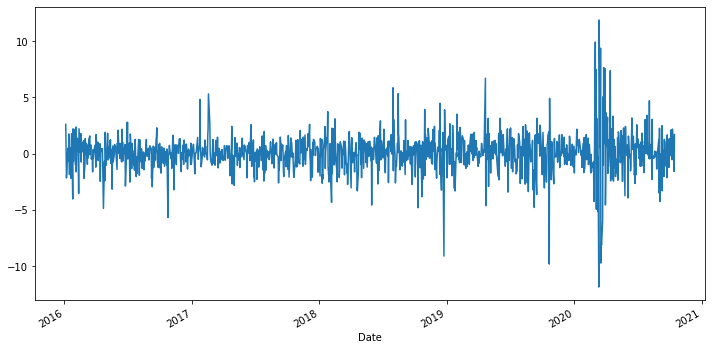

In [41]:
rcParams["figure.figsize"]=12, 6
#previous row
train["Close"].diff().plot()

### ACF and PACF of differenced series. 
Since the tools are for looking at stationary processes. When they cut the confidence interval for the first time. <br>
First we will look at differenced information.

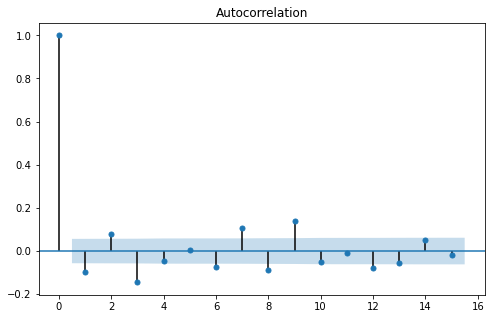

In [42]:
rcParams["figure.figsize"]=8, 5
#We will take the difference
plot_acf((train["Close"]-train["Close"].shift(1)).dropna(), lags = 15);

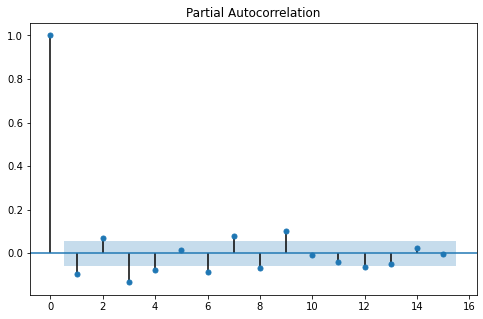

In [43]:
plot_pacf((train["Close"]-train["Close"].shift(1)).dropna(), lags = 15);
#I will use five since it is the first time it passes the frontier

### For (current) normal price information

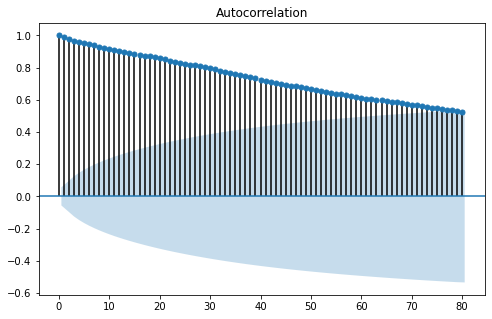

In [44]:
plot_acf(train["Close"], lags = 80);

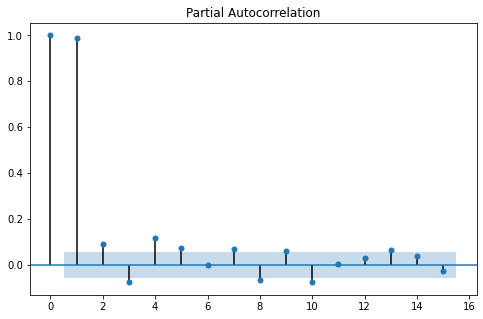

In [45]:
plot_pacf(train["Close"], lags = 15);
#I will use five since it is the first time it passes the frontier

### Scatter Plot of price vs price - 1

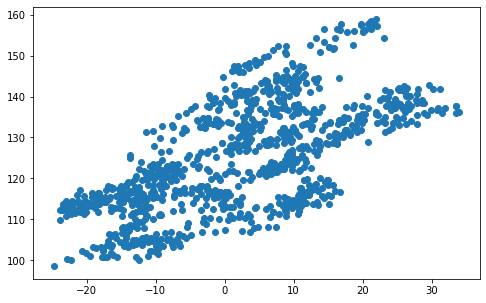

In [46]:
#have some linear pattern
plt.scatter((train["Close"]-train["Close"].shift(160)), train["Close"])
plt.show()

### AR: AutoRegressive Model
Predict based on past data

In [47]:
#Even though data is not stationary at all, please us it for illustrative purposes
ar = AutoReg((train["Close"]-train["Close"].shift(1)).dropna().to_numpy(), lags = 5).fit()

In [48]:
#I am just using valid values, you can use either predict or forecast, however I have found forecast is way better (might be due to in-sample and out-sample)
forecast = ar.predict(len(train)-1, (len(train)-1) + len(valid)-1)

In [49]:
#Remember this makes no sense with non-stationary data (our particular case)
forecast

array([-0.38684449,  0.34222794, -0.12927163, -0.03406202,  0.02671445,
        0.01032661,  0.04852596,  0.02207155,  0.02576002,  0.02038683,
        0.02163106,  0.02319441,  0.02326235,  0.02365113,  0.02323658,
        0.02318436,  0.02312193,  0.02315266,  0.02319029,  0.02319644,
        0.02319827,  0.02319006,  0.02318753,  0.02318696,  0.02318793,
        0.02318882,  0.02318897,  0.0231889 ,  0.02318871,  0.02318864,
        0.02318864,  0.02318867,  0.02318869,  0.0231887 ,  0.02318869,
        0.02318869,  0.02318869,  0.02318869,  0.02318869,  0.02318869,
        0.02318869,  0.02318869,  0.02318869])

In [50]:
valid_ar = valid.copy()
valid_ar["forecast"] = train["Close"].iloc[-1] + forecast.cumsum()

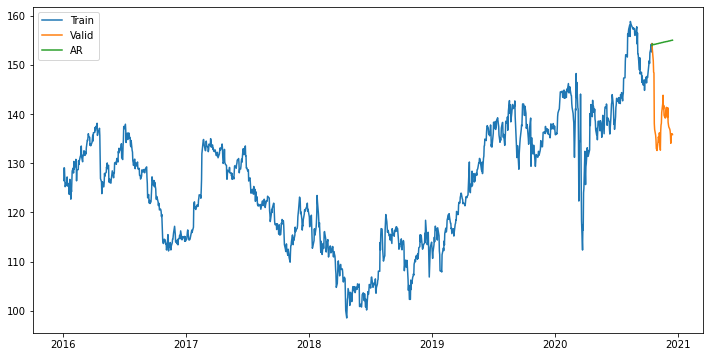

Root Mean Squared Error:
16.49388512862842


In [51]:
plt.figure(figsize = (12, 6))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid_ar['Close'], label = 'Valid')
plt.plot(valid_ar['forecast'], label = 'AR')
plt.legend(loc = 'best')
plt.show()
print("Root Mean Squared Error:")
rms = sqrt(mean_squared_error(valid_ar["Close"], valid_ar["forecast"]))
print(rms)

### ARMA model
Autoregressive moving average model. Therefore, you need autoregressive and moving average order. For example (1,1). Use PACF and ACF respectivelly to find orders, or do through grid search. Once they are not statistically significant (under the bands), proceede with that particular order. It requires the data to be stationary. 

In [52]:
#this is an ARMA model since we have d = 0
arma = ARIMA((train["Close"]-train["Close"].shift(1)).dropna().to_numpy(), order = (5, 0, 4)).fit()
arma.summary()
#our p values look good. Then might not be a very bad model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1205
Model:                     ARMA(5, 4)   Log Likelihood               -2335.852
Method:                       css-mle   S.D. of innovations              1.681
Date:                Tue, 22 Dec 2020   AIC                           4693.704
Time:                        20:54:06   BIC                           4749.741
Sample:                             0   HQIC                          4714.808
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0231      0.043      0.538      0.591      -0.061       0.107
ar.L1.y       -0.1539      0.135     -1.143      0.253      -0.418       0.110
ar.L2.y        0.7695      0.113      6.820      0.000       0.548       0.991
ar.L3.y       -0.2822      0.102     -2.779      0.005      -0.481      -0.083
ar.L4.y       -0.6707      0.082     -8.227      0.000      -0.830      -0.511
ar.L5.y        0.0708      0.044      1.614      0.106      -0.015       0.157
ma.L1.y        0.0801      0.132      0.606      0.545      -0.179       0.339
ma.L2.y       -0.7171      0.111     -6.465      0.000      -0.934      -0.500
ma.L3.y        0.2088      0.113      1.850      0.064      -0.012       0.430
ma.L4.y        0.5486      0.096      5.729      0.000       0.361       0.736
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0101           -0.4228j            1.0950           -0.4369
AR.2           -1.0101           +0.4228j            1.0950            0.4369
AR.3            0.8611           -0.6812j            1.0980           -0.1065
AR.4            0.8611           +0.6812j            1.0980            0.1065
AR.5            9.7717           -0.0000j            9.7717           -0.0000
MA.1            0.9110           -0.6569j            1.1232           -0.0994
MA.2            0.9110           +0.6569j            1.1232            0.0994
MA.3           -1.1013           -0.4816j            1.2020           -0.4344
MA.4           -1.1013           +0.4816j            1.2020            0.4344
-----------------------------------------------------------------------------
"""

### More ARIMA information
To fit the ARIMA model in our time series we have to find the optimized parameters (p, d, q)
To find the optimized values we will use ACF (Autocorrelation function)
and PACF (Partial Autocorrelation function).
* The value of p, is the lag the value where the PACF crosses the confidence interval for the first time.
* The q value, is where the lag value of the ACF graph, crossing the confidence interval for the first time.

Use ARIMA model **when the data is not stationary**, ergo, it has a trend (different mean over time). Performs a stationary transformation by substracting the difference of the month lagged by _d_; e.g. if _d_=1 the last month (observation). _p_ and _q_ are the same as in the ARMA model, and it is added _d_, for the integrated order.<br>
**Remember** keep orders as low as possible.

In [53]:
arima = ARIMA(train["Close"].to_numpy(), order = (6, 1, 6)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1205
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -2332.746
Method:                       css-mle   S.D. of innovations              1.677
Date:                Tue, 22 Dec 2020   AIC                           4693.491
Time:                        20:54:11   BIC                           4764.810
Sample:                             1   HQIC                          4720.351
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0230      0.042      0.548      0.584      -0.059       0.105
ar.L1.D.y     -0.0580      0.120     -0.485      0.628      -0.293       0.177
ar.L2.D.y     -0.1917      0.108     -1.771      0.077      -0.404       0.020
ar.L3.D.y     -0.5312      0.149     -3.562      0.000      -0.823      -0.239
ar.L4.D.y     -0.0612      0.095     -0.641      0.521      -0.248       0.126
ar.L5.D.y     -0.0410      0.082     -0.501      0.616      -0.201       0.119
ar.L6.D.y     -0.6905      0.080     -8.670      0.000      -0.847      -0.534
ma.L1.D.y     -0.0218      0.124     -0.176      0.860      -0.264       0.221
ma.L2.D.y      0.2628      0.107      2.453      0.014       0.053       0.473
ma.L3.D.y      0.3631      0.157      2.315      0.021       0.056       0.671
ma.L4.D.y     -0.0069      0.128     -0.054      0.957      -0.259       0.245
ma.L5.D.y      0.0389      0.110      0.353      0.724      -0.177       0.255
ma.L6.D.y      0.5991      0.112      5.339      0.000       0.379       0.819
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9678           -0.4656j            1.0739           -0.4286
AR.2           -0.9678           +0.4656j            1.0739            0.4286
AR.3            0.0960           -1.0324j            1.0368           -0.2352
AR.4            0.0960           +1.0324j            1.0368            0.2352
AR.5            0.8420           -0.6776j            1.0808           -0.1078
AR.6            0.8420           +0.6776j            1.0808            0.1078
MA.1            0.8870           -0.6680j            1.1104           -0.1027
MA.2            0.8870           +0.6680j            1.1104            0.1027
MA.3            0.0798           -1.0273j            1.0304           -0.2377
MA.4            0.0798           +1.0273j            1.0304            0.2377
MA.5           -0.9993           -0.5259j            1.1292           -0.4229
MA.6           -0.9993           +0.5259j            1.1292            0.4229
-----------------------------------------------------------------------------
"""

### Please try different values of p, d, q
Try improving the **mean squared error** on the valid set, in order to be more rigurous create a test set as well. You can also use an auto_arima tool (see below).<br>
I also included the **confidence intervals**, that might be a good tool for decision making.

In [54]:
#out of sample
valid_arima = valid.copy()
valid_arima["forecast"] = arima.forecast(len(valid))[0]

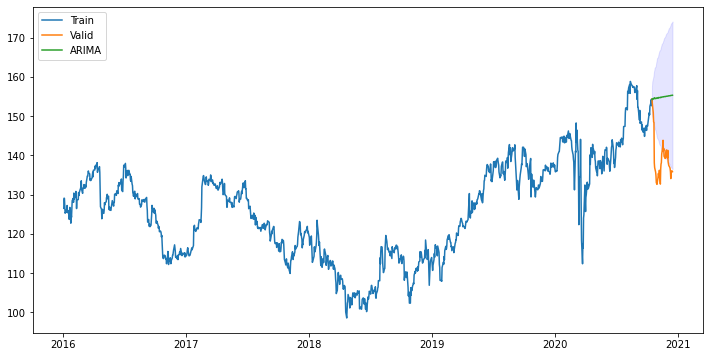

Root Mean Squared Error:
16.773260167905914


In [55]:
plt.figure(figsize = (12, 6))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid_arima['Close'], label = 'Valid')
plt.plot(valid_arima['forecast'], label = 'ARIMA')
plt.fill_between(valid_arima.index, arima.forecast(len(valid))[2][:,0], arima.forecast(len(valid))[2][:,1], color='b', alpha=.1)
plt.legend(loc = 'upper left')
plt.show()
print("Root Mean Squared Error:")
rms = sqrt(mean_squared_error(valid_arima["Close"], valid_arima["forecast"]))
print(rms)

### You can also try seasonality (SARIMA) and SARIMAX
A repeatative pattern within a year. For example ice cream has low sells on winter and high on summer and spring. If your data has seasonality you shall **NOT** use AR, ARMA, or ARIMA model. Seasonality and cycles are not the same, the latter are not predictable and occur with years, not neccesarily on a yearly basis, as seasonality. 
The **S** stands for seasonality. SARIMA models have 7 parameters: 3 already known, from ARIMA, 3 are analog to the first ones but for seasonality and _m_ is the seasonality factor (periods to be reapeted the patter): SARIMA(_p_,_d_,_q_) (_P_,_D_,_Q_)_m_

In [56]:
autoarima = auto_arima(train["Close"], start_p=0, start_q=0, max_p=8, max_q=20, seasonal = False)
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1206
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -2343.197
Date:                Tue, 22 Dec 2020   AIC                           4698.393
Time:                        20:54:21   BIC                           4728.958
Sample:                             0   HQIC                          4709.904
                               - 1206                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9112      0.036    -25.138      0.000      -0.982      -0.840
ar.L2         -0.0032      0.017     -0.190      0.849      -0.036       0.030
ar.L3         -0.0928      0.023     -3.974      0.000      -0.139      -0.047
ar.L4         -0.1906      0.018    -10.856      0.000      -0.225      -0.156
ma.L1          0.8379      0.039     21.559      0.000       0.762       0.914
sigma2         2.8607      0.060     47.873      0.000       2.744       2.978
===================================================================================
Ljung-Box (Q):                       48.66   Jarque-Bera (JB):              2730.75
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Recurrent Neural Networks

In [104]:
minmax = MinMaxScaler().fit(train[['Close']])
train_scaled = minmax.transform(train[['Close']])
generator = TimeseriesGenerator(train_scaled, train_scaled, length = 30, batch_size = 1) 

In [105]:
# define a model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (30, 1)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit_generator(generator, epochs = 25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
1176/1176 [==============================] - 39s 33ms/step - loss: 0.0047
Epoch 2/25
1176/1176 [==============================] - 43s 36ms/step - loss: 0.0019
Epoch 3/25
1176/1176 [==============================] - 44s 38ms/step - loss: 0.0016
Epoch 4/25
1176/1176 [==============================] - 43s 37ms/step - loss: 0.0014
Epoch 5/25
1176/1176 [==============================] - 37s 32ms/step - loss: 0.0012
Epoch 6/25
1176/1176 [==============================] - 36s 30ms/step - loss: 0.0011
Epoch 7/25
1176/1176 [==============================] - 35s 30ms/step - loss: 0.0011
Epoch 8/25
1176/1176 [==============================] - 32s 27ms/step - loss: 0.0010
Epoch 9/25
1176/1176 [==============================] - 35s 30ms/step - loss: 0.0011
Epoch 10/25
1176/1176 [==============================] - 35s 30ms/step - loss: 0.0010
Epoch 11/25
1176/1176 [==============================] - 32s 27ms/step - 

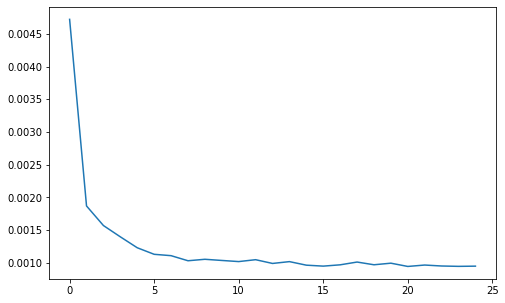

In [107]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])
plt.show()

In [109]:
valid_pred =[]
first_batch = train_scaled[-30:] #lenght 
current_batch = first_batch.reshape(1, 30, 1) #lenght and batch size
for i in range(len(valid)):
    current_pred = model.predict(current_batch)[0] 
    valid_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [110]:
valid_pred = minmax.inverse_transform(valid_pred)
valid['pred'] = valid_pred

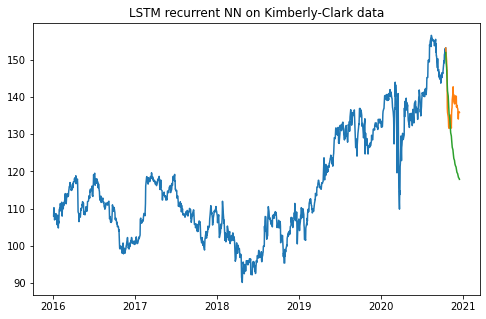

In [114]:
plt.plot(train['Adj Close'])
plt.plot(valid['Adj Close'])
plt.plot(valid['pred'])
plt.title("LSTM recurrent NN on Kimberly-Clark data")
plt.show()

### Next steps
Try facebook's prophet library!